In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
ls -l data

total 93192
-rw-rw-rw- 1 codespace codespace 47673370 Mar 20  2023 yellow_tripdata_2023-01.parquet
-rw-rw-rw- 1 codespace codespace 47748012 May  1  2023 yellow_tripdata_2023-02.parquet


In [5]:
!pip install pyarrow

## Q1. Downloading the data

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

In [7]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


#### Answer: 19 columns


## Q2. Computing duration

In [8]:
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

In [9]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [10]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [11]:
std_dev=df['duration'].std()

In [12]:
std_dev

42.594351241920904

#### Answer: standard deviation of the trips duration in January 42.59

## Q3. Dropping outliers

In [13]:
rows_before = len(df)
df = df[(df.duration >= 1) & (df.duration <= 60)]
rows_after = len(df)
percentage_left = (rows_after / rows_before) * 100

print(f'Percentage of rows left: {percentage_left}%')

Percentage of rows left: 98.1220282212598%


#### Answer: 98% records left after 

## Q4. One-hot encoding

In [14]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)


/tmp/ipykernel_46438/2090167467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [15]:
dv = DictVectorizer()
train_dicts = df[categorical].to_dict(orient='records')

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [17]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [18]:
target = 'duration'
y_train = df[target].values

In [19]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
num_columns = X_train.shape[1]
num_columns


515

#### Answer: dimensionality of this matrix is 515

## Q5. Training a model

In [22]:
y_pred = lr.predict(X_train)


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


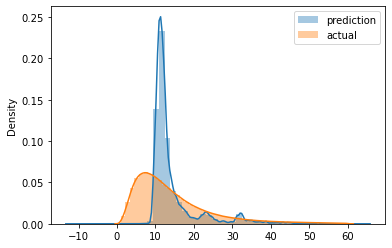

In [23]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [24]:
mean_squared_error(y_train, y_pred, squared=False)

7.6492610279057605

#### Answer: RMSE 7.64

## Q6. Evaluating the model

In [25]:
df = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [26]:
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

In [27]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

In [28]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [29]:
dv = DictVectorizer()
train_dicts = df[categorical].to_dict(orient='records')

In [30]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [31]:
X_train

<2855951x514 sparse matrix of type '<class 'numpy.float64'>'
	with 5711902 stored elements in Compressed Sparse Row format>

In [32]:
target = 'duration'
y_train = df[target].values

In [33]:
y_train

array([ 1.68333333, 32.08333333, 13.3       , ..., 14.        ,
        7.        ,  9.8       ])

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


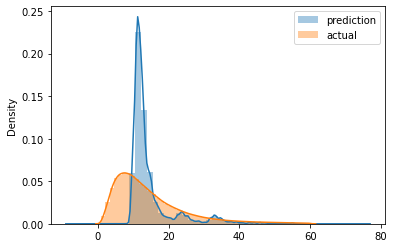

In [36]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [37]:
mean_squared_error(y_train, y_pred, squared=False)

7.778947591715993

#### Answer: RMSE 7.81